## Using Random Forest to Predict Click and Purchase Rates in Root Data

### Introduction

In this notebook, we attempt to develop a random forest model to predict the probability that a customer makes a click and a purchase. The predictors are $\mathtt{Currently\;Insured}$, $\mathtt{Number\;of\;Vehicles}$, $\mathtt{Number\;of\;Drivers}$, $\mathtt{Marital\;Status}$ and $\mathtt{rank}$. Since each of the predictors takes on a limited number (at most 5) of distinct values, we treat them as categorical variables and employ one-hot encoding to write them in terms of dummy variables.

We begin by loading the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
main = pd.read_csv("Root_Insurance_data.csv")
main.sample(10)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
688,unknown,1,1,S,10.0,3,False,0
720,N,3,1,M,10.0,5,False,0
7042,Y,2,1,S,10.0,5,False,0
9211,Y,1,1,S,10.0,2,True,0
4357,N,3,1,M,10.0,3,False,0
8563,unknown,2,2,S,10.0,1,True,0
8256,Y,1,1,S,10.0,3,False,0
7610,Y,2,2,M,10.0,4,False,0
4993,unknown,3,1,M,10.0,4,False,0
1,Y,3,1,M,10.0,5,False,0


Now, we use one-hot encoding on the predictors with more than two categories: $\mathtt{Currently\;Insured}$, $\mathtt{Number\;of\;Vehicles}$ and $\mathtt{rank}$.

In [3]:
main[["Insured_yes", "Insured_unknown"]] = pd.get_dummies(main["Currently Insured"])[["Y", "unknown"]]
main["Married"] = pd.get_dummies(main["Marital Status"])["M"]
main["Click_or_not"] = pd.get_dummies(main["click"])[True]
main["Two_Drivers"] = pd.get_dummies(main["Number of Drivers"])[2]
main["Two_Vehicles"] = pd.Series(data = [int(np.array(main["Number of Vehicles"])[i] == 2) for i in range(main.shape[0])], index = main.index)
main["Three_Vehicles"] = pd.Series(data = [int(np.array(main["Number of Vehicles"])[i] == 3) for i in range(main.shape[0])], index = main.index)
main["Rank_Two"] = pd.Series(data = [int(np.array(main["rank"])[i] == 2) for i in range(main.shape[0])], index = main.index)
main["Rank_Three"] = pd.Series(data = [int(np.array(main["rank"])[i] == 3) for i in range(main.shape[0])], index = main.index)
main["Rank_Four"] = pd.Series(data = [int(np.array(main["rank"])[i] == 4) for i in range(main.shape[0])], index = main.index)
main["Rank_Five"] = pd.Series(data = [int(np.array(main["rank"])[i] == 5) for i in range(main.shape[0])], index = main.index)

In [4]:
main.sample(10)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold,Insured_yes,Insured_unknown,Married,Click_or_not,Two_Drivers,Two_Vehicles,Three_Vehicles,Rank_Two,Rank_Three,Rank_Four,Rank_Five
6959,unknown,2,1,M,10.0,3,False,0,0,1,1,0,0,1,0,0,1,0,0
7113,unknown,2,1,M,10.0,3,False,0,0,1,1,0,0,1,0,0,1,0,0
30,Y,2,2,M,10.0,5,False,0,1,0,1,0,1,1,0,0,0,0,1
7636,N,2,2,S,10.0,4,True,1,0,0,0,1,1,1,0,0,0,1,0
3420,Y,2,1,S,10.0,5,False,0,1,0,0,0,0,1,0,0,0,0,1
4720,N,3,2,M,10.0,5,False,0,0,0,1,0,1,0,1,0,0,0,1
2231,N,1,2,M,10.0,2,False,0,0,0,1,0,1,0,0,1,0,0,0
3533,N,2,2,S,10.0,3,False,0,0,0,0,0,1,1,0,0,1,0,0
4390,unknown,1,2,M,10.0,1,False,0,0,1,1,0,1,0,0,0,0,0,0
3865,Y,1,2,M,10.0,2,True,0,1,0,1,1,1,0,0,1,0,0,0


Here, we put the predictors and targets in $\mathtt{NumPy}$ arrays.

In [5]:
predictors = ["Insured_yes", "Insured_unknown", "Two_Vehicles", "Three_Vehicles", "Two_Drivers", "Married",
             "Rank_Two", "Rank_Three", "Rank_Four", "Rank_Five"]
X = np.array(main[predictors])
y1 = np.array(main["Click_or_not"])
y2 = np.array(main["policies_sold"])

The following function converts the human input (according to the original Root's table entry) into the $1\times p$ numpy array that can later be fed to the model in order to make predictions.

In [6]:
def features_to_X(insured, n_vehicles, n_drivers, marital_status, rank):
    ans = np.zeros(10)
    if insured == "Y":
        ans[0] = 1
    elif insured == "unknown":
        ans[1] = 1
    if n_vehicles == 2:
        ans[2] = 1
    elif n_vehicles == 3:
        ans[3] = 1
    if n_drivers == 2:
        ans[4] = 1
    if marital_status == "M":
        ans[5] = 1
    if rank == 2:
        ans[6] = 1
    elif rank == 3:
        ans[7] = 1
    elif rank == 4:
        ans[8] = 1
    elif rank == 5:
        ans[9] = 1
    return ans

### Click Rate Prediction

Here, we make a train-test split with stratification. The random state and test set size are agreed upon by the group.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.25, random_state=614, stratify=y2)

We perform a 5-fold cross validation to tune our model for the maximum depth and the number of trees. The former has a bias-variance tradeoff, that is, random forests with too-low maximum depths will underfit, while too-high maximum depths lead to overfitting. Although it is common knowledge that too many trees in a random forest do not lead to overfitting, we would prefer to use the smallest number of trees possible while still getting a good fit, in order to reduce computational cost.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [10]:
n_estimators_list = [1,2,5,10,20,50,100,200,500,1000]
max_depth_list = [i for i in range(1,11)] + [15, 20, 30, 50]
accs = np.empty((5, len(n_estimators_list), len(max_depth_list)))
aucs = np.empty((5, len(n_estimators_list), len(max_depth_list)))
pr_aucs = np.empty((5, len(n_estimators_list), len(max_depth_list)))
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=614)
i = 0
for train_idx, val_idx in kfold.split(X1_train, y1_train):
    Xtr, Xval = X1_train[train_idx], X1_train[val_idx]
    ytr, yval = y1_train[train_idx], y1_train[val_idx]
    for j in range(len(n_estimators_list)):
        for k in range(len(max_depth_list)):
            rf11 = RandomForestClassifier(n_estimators = n_estimators_list[j], 
                                          max_depth = max_depth_list[k], 
                                          random_state = 614)
            rf11.fit(Xtr, ytr)
            pred = rf11.predict(Xval)
            prob = rf11.predict_proba(Xval)
            accs[i, j, k] = accuracy_score(yval, pred)
            aucs[i, j, k] = roc_auc_score(yval, prob[:,1])
            precision, recall, _ = precision_recall_curve(yval, prob[:,1])
            pr_aucs[i, j, k] = auc(recall, precision)
    i += 1
accuracies11 = accs.mean(axis = 0)
auc_scores11 = aucs.mean(axis = 0)
pr_auc_scores11 = pr_aucs.mean(axis = 0)

Since the overall click rate in the data set is below 20%, the data set is considered unbalanced. So, we decide to use the area under the precision-recall curve (PRAUC) to evaluate the models. 

We first consider the PRAUC scores for different maximum depths. 

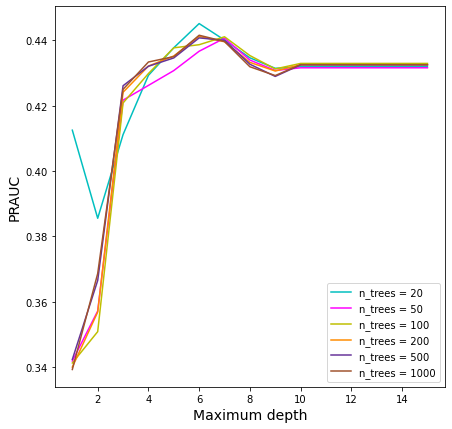

In [11]:
max_depth_list = [i for i in range(1,11)] + [15, 20, 30, 50]
plt.figure(figsize = (7,7))
#plt.plot(max_depth_list[:-3], pr_auc_scores11[0, :-3], label = "n_trees = 1", color = "r")
#plt.plot(max_depth_list[:-3], pr_auc_scores11[1, :-3], label = "n_trees = 2", color = "b")
#plt.plot(max_depth_list[:-3], pr_auc_scores11[2, :-3], label = "n_trees = 5", color = "k")
#plt.plot(max_depth_list[:-3], pr_auc_scores11[3, :-3], label = "n_trees = 10", color = "g")
plt.plot(max_depth_list[:-3], pr_auc_scores11[4, :-3], label = "n_trees = 20", color = "c")
plt.plot(max_depth_list[:-3], pr_auc_scores11[5, :-3], label = "n_trees = 50", color = "magenta")
plt.plot(max_depth_list[:-3], pr_auc_scores11[6, :-3], label = "n_trees = 100", color = "y")
plt.plot(max_depth_list[:-3], pr_auc_scores11[7, :-3], label = "n_trees = 200", color = "darkorange")
plt.plot(max_depth_list[:-3], pr_auc_scores11[8, :-3], label = "n_trees = 500", color = "rebeccapurple")
plt.plot(max_depth_list[:-3], pr_auc_scores11[9, :-3], label = "n_trees = 1000", color = "sienna")
plt.xlabel("Maximum depth", fontsize = 14)
plt.ylabel("PRAUC", fontsize = 14)
plt.legend(fontsize = 10)
plt.show()

The PRAUC plot shows a peak around maximum depth of 6 or 7, with the maximum at 6 for any models with at least 200 trees. This implies that random forests with larger maximum depths tend to overfit while those with smaller maximum depths tend to underfit.

Now, we look at PRAUC scores for different numbers of trees.

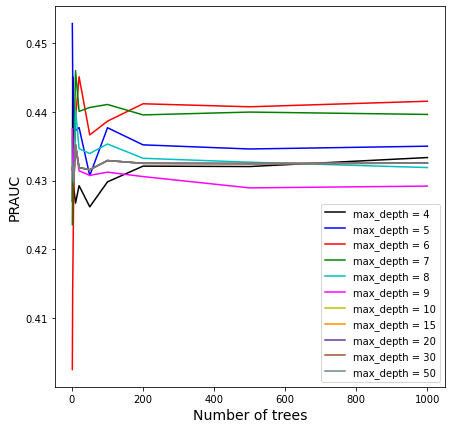

In [12]:
plt.figure(figsize = (7,7))
plt.plot(n_estimators_list, pr_auc_scores11[:, 3], label = "max_depth = 4", color = "k")
plt.plot(n_estimators_list, pr_auc_scores11[:, 4], label = "max_depth = 5", color = "b")
plt.plot(n_estimators_list, pr_auc_scores11[:, 5], label = "max_depth = 6", color = "r")
plt.plot(n_estimators_list, pr_auc_scores11[:, 6], label = "max_depth = 7", color = "g")
plt.plot(n_estimators_list, pr_auc_scores11[:, 7], label = "max_depth = 8", color = "c")
plt.plot(n_estimators_list, pr_auc_scores11[:, 8], label = "max_depth = 9", color = "magenta")
plt.plot(n_estimators_list, pr_auc_scores11[:, 9], label = "max_depth = 10", color = "y")
plt.plot(n_estimators_list, pr_auc_scores11[:, 10], label = "max_depth = 15", color = "darkorange")
plt.plot(n_estimators_list, pr_auc_scores11[:, 11], label = "max_depth = 20", color = "rebeccapurple")
plt.plot(n_estimators_list, pr_auc_scores11[:, 12], label = "max_depth = 30", color = "sienna")
plt.plot(n_estimators_list, pr_auc_scores11[:, 13], label = "max_depth = 50", color = "slategray")
plt.xlabel("Number of trees", fontsize = 14)
plt.ylabel("PRAUC", fontsize = 14)
plt.legend(fontsize = 10)
plt.show()

As expected, the PRAUC score levels off at its maximum for 200+ trees. From now on, we will lean on the safe side and use 250 trees. For this many trees, the PRAUC vs Maximum depth plot shows that we should proceed with the maximum depth of 6.

We will now run the final random forest for the whole training set, using 250 trees with maximum depth of 6.

In [13]:
rf11_final = RandomForestClassifier(n_estimators = 250, 
                                          max_depth = 6, 
                                          random_state = 614)
rf11_final.fit(X1_train, y1_train)

RandomForestClassifier(max_depth=6, n_estimators=250, random_state=614)

This is the PRAUC score for the final model.

In [15]:
precision_11, recall_11, _ = precision_recall_curve(y1_test, rf11.predict_proba(X1_test)[:,1])
test_pr_auc11 = auc(recall_11, precision_11)
print("Random forest test PR-AUC for click rate:", test_pr_auc11)

Random forest test PR-AUC for click rate: 0.470015322725361


### Purchase Rate Prediction

Again, we start by performing a train-test split.

In [16]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.25, random_state=614, stratify=y2)

Similarly, we use a 5-fold cross validation to tune our model for the maximum depth and the number of trees. 

In [17]:
n_estimators_list = [1,2,5,10,20,50,100,200,500]
max_depth_list = [i for i in range(1,11)] + [15, 20, 30]
accs = np.empty((5, len(n_estimators_list), len(max_depth_list)))
aucs = np.empty((5, len(n_estimators_list), len(max_depth_list)))
pr_aucs = np.empty((5, len(n_estimators_list), len(max_depth_list)))
kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state=614)
i = 0
for train_idx, val_idx in kfold.split(X2_train, y2_train):
    Xtr, Xval = X2_train[train_idx], X2_train[val_idx]
    ytr, yval = y2_train[train_idx], y2_train[val_idx]
    for j in range(len(n_estimators_list)):
        for k in range(len(max_depth_list)):
            rf21 = RandomForestClassifier(n_estimators = n_estimators_list[j], 
                                          max_depth = max_depth_list[k], 
                                          random_state = 614)
            rf21.fit(Xtr, ytr)
            pred = rf21.predict(Xval)
            prob = rf21.predict_proba(Xval)
            accs[i, j, k] = accuracy_score(yval, pred)
            aucs[i, j, k] = roc_auc_score(yval, prob[:,1])
            precision, recall, _ = precision_recall_curve(yval, prob[:,1])
            pr_aucs[i, j, k] = auc(recall, precision)
    i += 1
accuracies21 = accs.mean(axis = 0)
auc_scores21 = aucs.mean(axis = 0)
pr_auc_scores21 = pr_aucs.mean(axis = 0)

Now, we compare the PRAUC scores for different maximum depths.

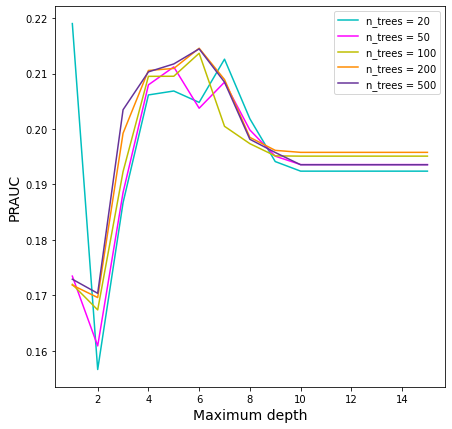

In [18]:
max_depth_list = [i for i in range(1,11)] + [15, 20, 30]
plt.figure(figsize = (7,7))
#plt.plot(max_depth_list[:-2], pr_auc_scores21[0, :-2], label = "n_trees = 1", color = "r")
#plt.plot(max_depth_list[:-2], pr_auc_scores21[1, :-2], label = "n_trees = 2", color = "b")
#plt.plot(max_depth_list[:-2], pr_auc_scores21[2, :-2], label = "n_trees = 5", color = "k")
#plt.plot(max_depth_list[:-2], pr_auc_scores21[3, :-2], label = "n_trees = 10", color = "g")
plt.plot(max_depth_list[:-2], pr_auc_scores21[4, :-2], label = "n_trees = 20", color = "c")
plt.plot(max_depth_list[:-2], pr_auc_scores21[5, :-2], label = "n_trees = 50", color = "magenta")
plt.plot(max_depth_list[:-2], pr_auc_scores21[6, :-2], label = "n_trees = 100", color = "y")
plt.plot(max_depth_list[:-2], pr_auc_scores21[7, :-2], label = "n_trees = 200", color = "darkorange")
plt.plot(max_depth_list[:-2], pr_auc_scores21[8, :-2], label = "n_trees = 500", color = "rebeccapurple")
plt.xlabel("Maximum depth", fontsize = 14)
plt.ylabel("PRAUC", fontsize = 14)
plt.legend(fontsize = 10)
plt.show()

We see that the maximum depth of 6 gives the best cross-validation PRAUC for models with at least 100 trees.

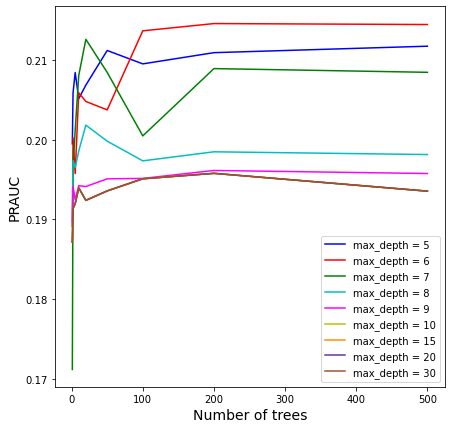

In [19]:
plt.figure(figsize = (7,7))
#plt.plot(n_estimators_list, pr_auc_scores21[:, 3], label = "max_depth = 4", color = "k")
plt.plot(n_estimators_list, pr_auc_scores21[:, 4], label = "max_depth = 5", color = "b")
plt.plot(n_estimators_list, pr_auc_scores21[:, 5], label = "max_depth = 6", color = "r")
plt.plot(n_estimators_list, pr_auc_scores21[:, 6], label = "max_depth = 7", color = "g")
plt.plot(n_estimators_list, pr_auc_scores21[:, 7], label = "max_depth = 8", color = "c")
plt.plot(n_estimators_list, pr_auc_scores21[:, 8], label = "max_depth = 9", color = "magenta")
plt.plot(n_estimators_list, pr_auc_scores21[:, 9], label = "max_depth = 10", color = "y")
plt.plot(n_estimators_list, pr_auc_scores21[:, 10], label = "max_depth = 15", color = "darkorange")
plt.plot(n_estimators_list, pr_auc_scores21[:, 11], label = "max_depth = 20", color = "rebeccapurple")
plt.plot(n_estimators_list, pr_auc_scores21[:, 12], label = "max_depth = 30", color = "sienna")
plt.xlabel("Number of trees", fontsize = 14)
plt.ylabel("PRAUC", fontsize = 14)
plt.legend(fontsize = 10)
plt.show()

At the best maximum depth of 6, the PRAUC score reaches its maximum and levels off at 200 trees. 

In the following, we run the final random forest model to predict the purchase rate, using 200 trees with maximum depth of 6.

In [20]:
rf21_final = RandomForestClassifier(n_estimators = 200, 
                                          max_depth = 6, 
                                          random_state = 614)
rf21_final.fit(X2_train, y2_train)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=614)

This is the PRAUC score for the final model.

In [21]:
precision_21, recall_21, _ = precision_recall_curve(y2_test, rf21.predict_proba(X2_test)[:,1])
test_pr_auc21 = auc(recall_21, precision_21)
print("Random forest test PR-AUC for purchase rate:", test_pr_auc21)

Random forest test PR-AUC for purchase rate: 0.18571275721278188


### Final Prediction for Various Categories

In order to put our random forest models to use, we define the following functions that return click and purchase rates given the inputs in the following form.
- $\mathtt{insured} \in \{\mathtt{"Y"}, \mathtt{\;"N"}, \mathtt{\;"unknown"}\}$
- $\mathtt{n\_vehicles} \in \{1, 2, 3\}$
- $\mathtt{n\_drivers} \in \{1, 2\}$
- $\mathtt{marital\_status} \in \{\mathtt{"S"}, \mathtt{\;"M"}\}$
- $\mathtt{rank} \in \{1, 2, 3, 4, 5\}$

In [22]:
def get_click_rate(insured, n_vehicles, n_drivers, marital_status, rank):
    X = features_to_X(insured, n_vehicles, n_drivers, marital_status, rank)
    prob_click = rf11.predict_proba(np.transpose(X.reshape(-1,1)))[0,1]
    return prob_click

In [23]:
def get_purchase_rate(insured, n_vehicles, n_drivers, marital_status, rank):
    X = features_to_X(insured, n_vehicles, n_drivers, marital_status, rank)
    prob_purchase = rf21.predict_proba(np.transpose(X.reshape(-1,1)))[0,1]
    return prob_purchase

Now, we define the lists of columns that will eventually yield all the combinations of features, then we compute the probabilities of click and purchase for all the combinations. 

In [24]:
insured_list_full = ["Y" for i in range(60)] + ["N" for i in range(60)] + ["unknown" for i in range(60)]
n_vehicles_list_full = ([1 for i in range(20)] + [2 for i in range(20)] + [3 for i in range(20)])*3
n_drivers_list_full = ([1 for i in range(10)] + [2 for i in range(10)])*9
marital_status_list_full = (["S" for i in range(5)] + ["M" for i in range(5)])*18
rank_list_full = [i for i in range(1,6)]*36

In [25]:
click_rates = [get_click_rate(insured_list_full[i], 
                              n_vehicles_list_full[i],
                              n_drivers_list_full[i],
                              marital_status_list_full[i],
                              rank_list_full[i]) for i in range(180)]
sales_rates = [get_purchase_rate(insured_list_full[i], 
                                 n_vehicles_list_full[i],
                                 n_drivers_list_full[i],
                                 marital_status_list_full[i],
                                 rank_list_full[i]) for i in range(180)]

Finally, we put all the predicted probabilities into a dataframe and save it as a csv file called "rf_onehot_predictions.csv". 

Note to the readers: this csv file will not be posted on the GitHub repository, but we posted another file named "predict_proba_averaged.csv", which is a more comprehensive csv file containing the probability predictions from all of our models.

In [26]:
rf_onehot_df = pd.DataFrame({"Currently Insured": insured_list_full,
                             "Number of Vehicles": n_vehicles_list_full,
                             "Number of Drivers": n_drivers_list_full,
                             "Marital Status": marital_status_list_full,
                             "rank": rank_list_full,
                             "Click Rates": click_rates,
                             "Purchase Rates": sales_rates})

In [28]:
rf_onehot_df.to_csv("rf_onehot_predictions.csv")

In [27]:
rf_onehot_df.sample(10)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,rank,Click Rates,Purchase Rates
152,unknown,2,2,S,3,0.130541,0.029952
133,unknown,1,2,S,4,0.240350,0.103322
166,unknown,3,1,M,2,0.241065,0.095077
118,N,3,2,M,4,0.091753,0.064016
104,N,3,1,S,5,0.013821,0.000000
148,unknown,2,1,M,4,0.185694,0.092267
103,N,3,1,S,4,0.087468,0.049907
30,Y,2,2,S,1,0.243025,0.115484
23,Y,2,1,S,4,0.120312,0.023010
56,Y,3,2,M,2,0.252134,0.044307
